# Advanced Statistics for Physics - Exam

## Boosted Decision Tree

In [1]:
# load libraries
library(caret)
library(xgboost)
library(RColorBrewer)

Loading required package: lattice
Loading required package: ggplot2


In [2]:
# load dataset
background.path <- "data/background.csv"
signal.path     <- "data/MC_signal.csv"
data_lhcb.path  <- "data/data_lhcb.csv"


background <- read.csv(background.path, row.names=1) # label 0
signal     <- read.csv(signal.path, row.names=1)     # label 1

data_lhcb  <- read.csv(data_lhcb.path, row.names=1)  # real data

In [3]:
# keep only significant features

features <- c("Lambda_c_MM_F",      # mass Lambda_c 
              "lc_p_ProbNNp_F",     # prob Lambda_c p identified as a p 
              "lcZDecLSigma_F",     # Lambda_c z decay length over error 
              "lcstarZDecLSigma_F", # Lambda_c* z decay length over error
              "lcDecTime_F",        # Lambda_c decay time
              "lcstarDecTime_F",    # Lambda_c* decay time
              "lbDecTime_F",        # Lambda_b decay time
              "lcDecVerChi2_F",     # prob of Lambda_c Chi2 vertex
              "lcstarDecVerChi2_F", # prob of Lambda_c* Chi2 vertex
              "Lambda_b0_DIRA_OWNPV_F", # Lambda_0 DIRA of PV
              "pair0_3pi_F",        # pair mass pi_0 and pi_1 
              "pair1_3pi_F"         # pair mass pi_1 and pi_2
             )

signal     <- signal[features]
background <- background[features]

data_lhcb  <- data_lhcb[features]

In [17]:
str(signal); cat("\n\n"); str(background); cat("\n\n"); str(data_lhcb)

'data.frame':	1490 obs. of  12 variables:
 $ Lambda_c_MM_F         : num  2285 2283 2292 2302 2281 ...
 $ lc_p_ProbNNp_F        : num  0.992 0.888 0.999 0.896 0.826 ...
 $ lcZDecLSigma_F        : num  0.409 1.375 4.896 0.418 1.331 ...
 $ lcstarZDecLSigma_F    : num  0.805 1.1153 -0.0737 -0.4422 -0.2064 ...
 $ lcDecTime_F           : num  0.0499 0.093 0.403 0.0292 0.1183 ...
 $ lcstarDecTime_F       : num  0.3398 0.1569 -0.0139 -0.1831 -0.069 ...
 $ lbDecTime_F           : num  2.26 1.79 1.75 3.68 3.02 ...
 $ lcDecVerChi2_F        : num  0.214 0.358 0.7071 0.9974 0.0623 ...
 $ lcstarDecVerChi2_F    : num  0.1127 0.5803 0.3356 0.0922 0.7364 ...
 $ Lambda_b0_DIRA_OWNPV_F: num  1 1 1 1 1 ...
 $ pair0_3pi_F           : num  1310 643 798 1203 622 ...
 $ pair1_3pi_F           : num  754 572 813 748 567 ...


'data.frame':	13518 obs. of  12 variables:
 $ Lambda_c_MM_F         : num  2308 2308 2308 2287 2280 ...
 $ lc_p_ProbNNp_F        : num  0.999 0.999 0.999 0.991 0.974 ...
 $ lcZDecLSigma_F

In [4]:
# separation of the dataset into train and test set
# 80% of the dataset is used for training

# signal
train.signal       <- signal[1:(as.integer(nrow(signal)*0.8)),]
train.label.signal <- replicate(nrow(train.signal),1)

test.signal        <- signal[(as.integer(nrow(signal)*0.8)+1):nrow(signal),]
test.label.signal  <- replicate(nrow(test.signal),1)

# background
train.background       <- background[1:(as.integer(nrow(background)*0.8)),]
train.label.background <- replicate(nrow(train.background),0)

test.background        <- background[(as.integer(nrow(background)*0.8)+1):nrow(background),]
test.label.background  <- replicate(nrow(test.background),0)

# final training and test set
train       <- rbind(train.signal,train.background)
train.label <- c(train.label.signal,train.label.background)
# shuffle data order in the training set
set.seed(20190630)
shuffle     <- sample(length(train.label))
train       <- train[shuffle,]
train.label <- train.label[shuffle]

test        <- rbind(test.signal,test.background)
test.label  <- c(test.label.signal,test.label.background)

# save the entire MC dataset to train the best model before making predictions on real data
MC          <- rbind(train, test)
MC.label    <- c(train.label, test.label)

# convert train, test and MC into matrix, as it is required for the analysis with xgboost package 
train <- as.matrix(train)
test  <- as.matrix(test)
MC    <- as.matrix(MC)

#str(train); str(train.label)
#str(test) ; str(test.label)

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
615,750,5,0.3,0,1,1,1


png 
  2

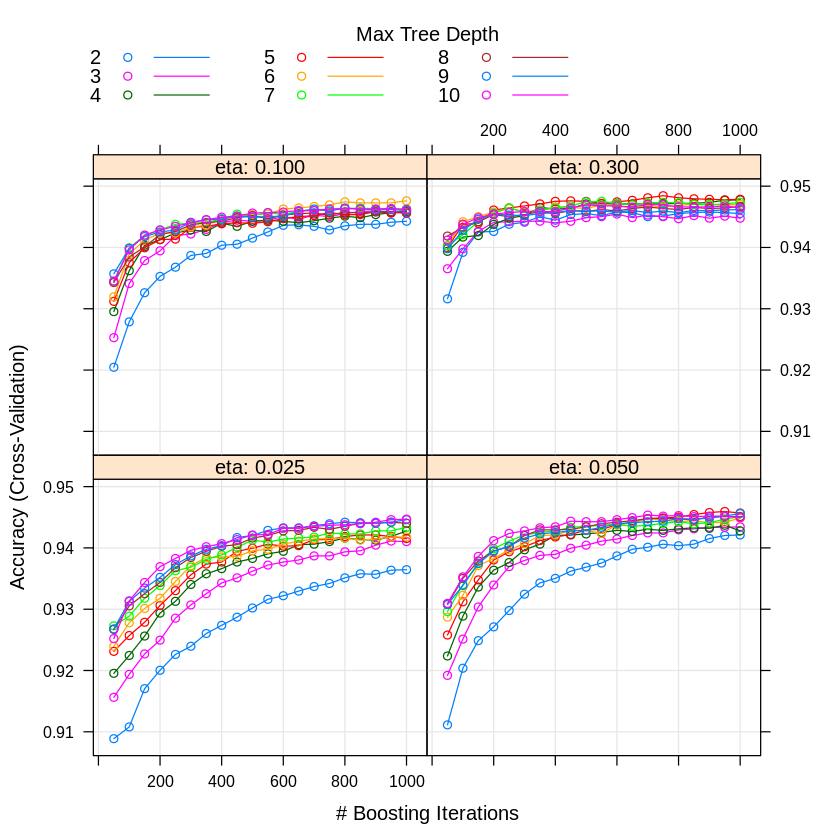

In [5]:
# reference for parameter tuning:
# https://www.kaggle.com/pelkoja/visual-xgboost-tuning-with-caret

# tuning eta and n

set.seed(20190704)

tune_control <- caret::trainControl(    
    method        = "cv", # cross-validation
    number        = 3,    # with n folds
    verboseIter   = FALSE,
    allowParallel = TRUE
)

tune_grid.1 <- expand.grid(
    nrounds          = seq(from=50, to=1000, by=50),
    eta              = c(0.025, 0.05, 0.1, 0.3),
    max_depth        = 2:10,
    gamma            = 0,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample        = 1
)

xgb_tune.1 <- caret::train(
    x         = train,
    y         = as.factor(train.label),
    trControl = tune_control,
    tuneGrid  = tune_grid.1,
    method    = "xgbTree",
    verbose   = TRUE
)

xgb_tune.1$bestTune
plot(xgb_tune.1)
pdf("Figure/BDT/xgb_tune_1.pdf")
plot(xgb_tune.1)
dev.off()

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
96,775,5,0.3,0,1,5,1


png 
  2

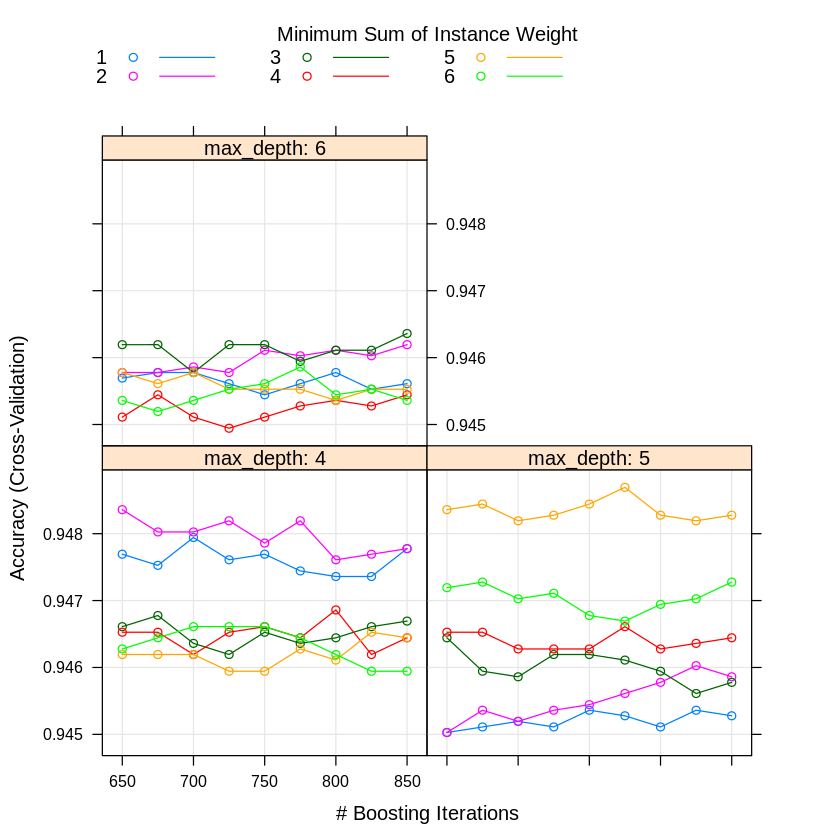

In [6]:
# tuning min_child_weight

tune_grid.2 <- expand.grid(
    nrounds          = seq(from=xgb_tune.1$bestTune$nrounds-100, to=xgb_tune.1$bestTune$nrounds+100, by=25),
    eta              = xgb_tune.1$bestTune$eta,
    max_depth        = (xgb_tune.1$bestTune$max_depth-1):(xgb_tune.1$bestTune$max_depth+1),
    gamma            = 0,
    colsample_bytree = 1,
    min_child_weight = 1:6,
    subsample        = 1
)

xgb_tune.2 <- caret::train(
    x         = train,
    y         = as.factor(train.label),
    trControl = tune_control,
    tuneGrid  = tune_grid.2,
    method    = "xgbTree",
    verbose   = TRUE
)

xgb_tune.2$bestTune
plot(xgb_tune.2)
pdf("Figure/BDT/xgb_tune_2.pdf")
plot(xgb_tune.2)
dev.off()

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
56,775,5,0.3,0.1,0.8,5,1


png 
  2

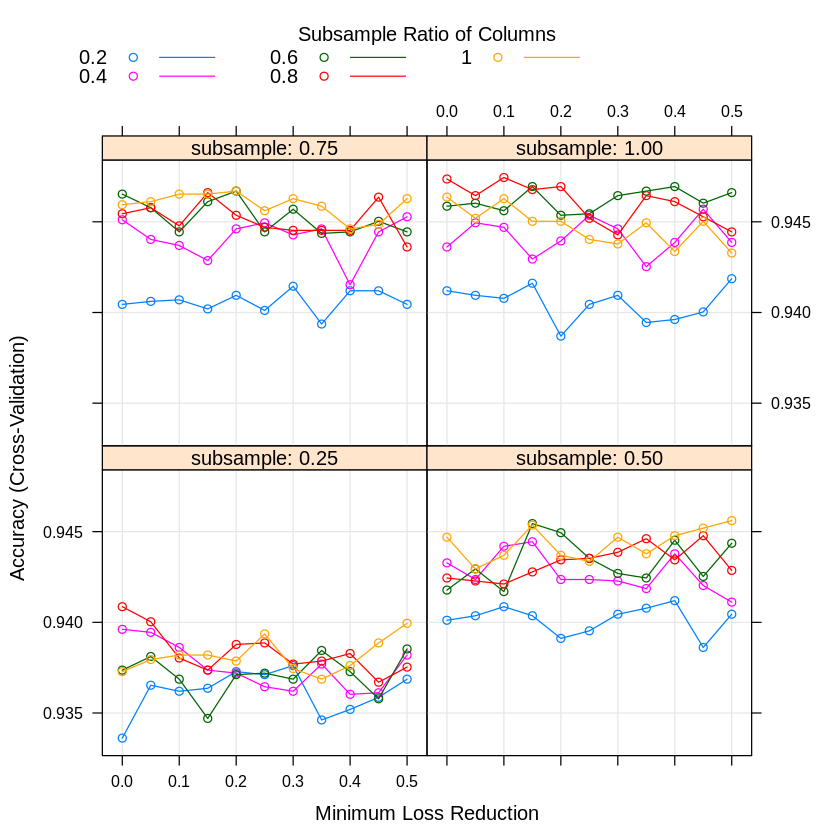

In [7]:
# tuning row and column sampling and gamma

tune_grid.3 <- expand.grid(
    nrounds          = xgb_tune.2$bestTune$nrounds,
    eta              = xgb_tune.2$bestTune$eta,
    max_depth        = xgb_tune.2$bestTune$max_depth,
    gamma            = seq(from=0, to=0.5, by=0.05),
    colsample_bytree = seq(from=0.2, to=1.0, by=0.2),
    min_child_weight = xgb_tune.2$bestTune$min_child_weight,
    subsample        = seq(from=0.25, to=1.0, by=0.25)
)

xgb_tune.3 <- caret::train(
    x         = train,
    y         = as.factor(train.label),
    trControl = tune_control,
    tuneGrid  = tune_grid.3,
    method    = "xgbTree",
    verbose   = TRUE
)

xgb_tune.3$bestTune
plot(xgb_tune.3)
pdf("Figure/BDT/xgb_tune_3.pdf")
plot(xgb_tune.3)
dev.off()

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
110,1500,5,0.075,0.1,0.8,5,1


png 
  2

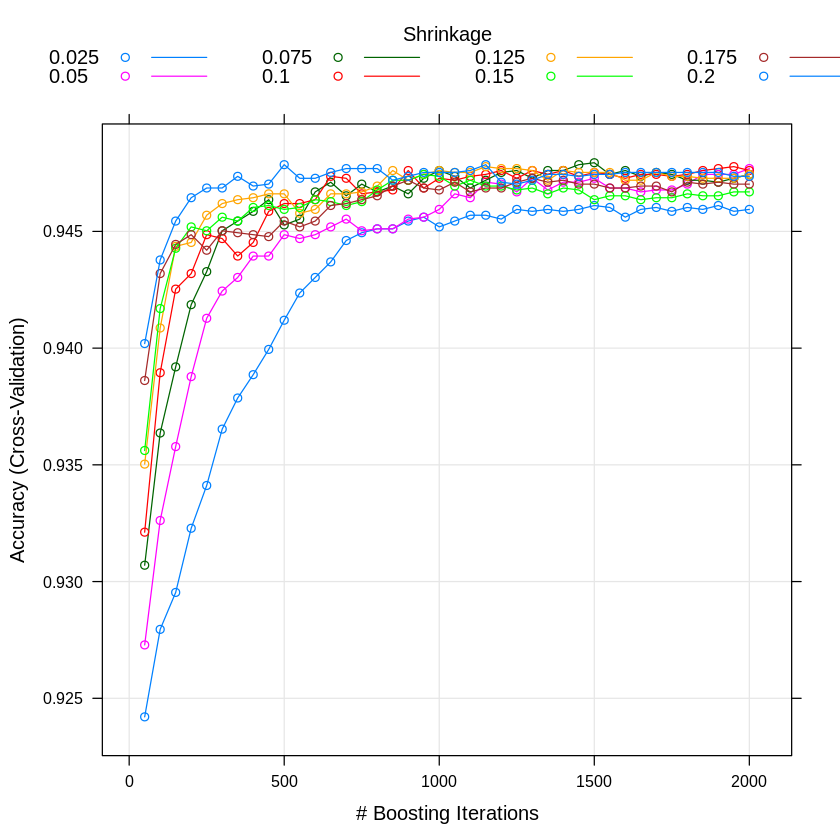

In [8]:
# fine tuning eta and nrounds

tune_grid.4 <- expand.grid(
    nrounds          = seq(from=50, to=2000, by=50),
    eta              = seq(from=0.025, to=0.2, by=0.025),
    max_depth        = xgb_tune.3$bestTune$max_depth,
    gamma            = xgb_tune.3$bestTune$gamma,
    colsample_bytree = xgb_tune.3$bestTune$colsample_bytree,
    min_child_weight = xgb_tune.3$bestTune$min_child_weight,
    subsample        = xgb_tune.3$bestTune$subsample
)

xgb_tune.4 <- caret::train(
    x         = train,
    y         = as.factor(train.label),
    trControl = tune_control,
    tuneGrid  = tune_grid.4,
    method    = "xgbTree",
    verbose   = TRUE
)

xgb_tune.4$bestTune
plot(xgb_tune.4)
pdf("Figure/BDT/xgb_tune_4.pdf")
plot(xgb_tune.4)
dev.off()

In [9]:
# fitting the best model with caret, in order to estimate error and accuracy

tune_grid.final <- expand.grid(  
    nrounds          = xgb_tune.4$bestTune$nrounds,
    eta              = xgb_tune.4$bestTune$eta,
    max_depth        = xgb_tune.4$bestTune$max_depth,
    gamma            = xgb_tune.4$bestTune$gamma,
    colsample_bytree = xgb_tune.4$bestTune$colsample_bytree,
    min_child_weight = xgb_tune.4$bestTune$min_child_weight,
    subsample        = xgb_tune.4$bestTune$subsample
)

xgb_tune.final <- caret::train(
    x         = train,
    y         = as.factor(train.label),
    trControl = tune_control,
    tuneGrid  = tune_grid.final,
    method    = "xgbTree",
    verbose   = TRUE
)

# summary of the best xgb model
xgb_tune.final$results

# performance on test set
test.label   <- as.factor(test.label)
test.predict <- predict(xgb_tune.final, newdata=test)

error    <- mean(test.predict != test.label)
accuracy <- 1-error

cat("Accuracy/Error on test set: ", accuracy, " / ", error)

nrounds,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1500,0.075,5,0.1,0.8,5,1,0.9465265,0.6683961,0.00196246,0.01763192


Accuracy/Error on test set:  0.9327115  /  0.06728847

                   Feature       Gain      Cover  Frequency
 1: Lambda_b0_DIRA_OWNPV_F 0.21523366 0.21559865 0.30799596
 2:         lc_p_ProbNNp_F 0.11274651 0.07113653 0.06306803
 3:            pair1_3pi_F 0.10497695 0.07287514 0.06146149
 4:            pair0_3pi_F 0.10104917 0.06923601 0.05558616
 5:          Lambda_c_MM_F 0.07563498 0.07047864 0.06426145
 6:         lcZDecLSigma_F 0.07539155 0.09019159 0.07302855
 7:        lcstarDecTime_F 0.07397986 0.10444469 0.07844487
 8:     lcstarZDecLSigma_F 0.06497152 0.09065116 0.06862205
 9:            lcDecTime_F 0.06110889 0.08996189 0.06701551
10:            lbDecTime_F 0.05102840 0.05154589 0.05861562
11:     lcstarDecVerChi2_F 0.03345592 0.03518345 0.04507482
12:         lcDecVerChi2_F 0.03042259 0.03869636 0.05682548


png 
  2

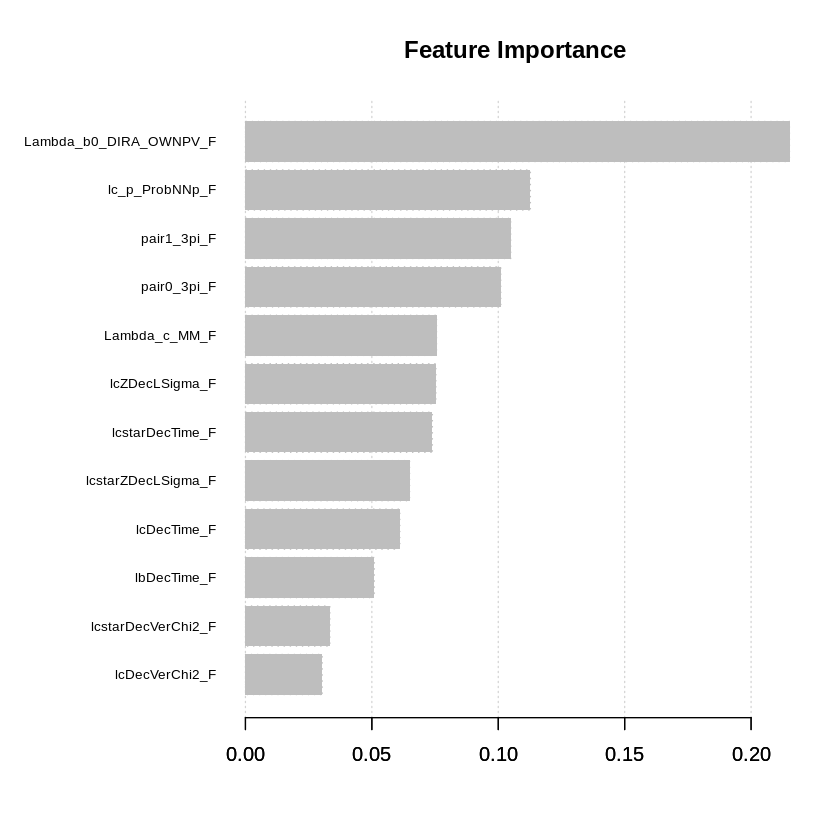

In [12]:
# fitting the best model with xgboost function using the entire MC dataset 

xgb_final <- xgb.train(nrounds          = xgb_tune.final$bestTune$nrounds, 
                       eta              = xgb_tune.final$bestTune$eta,
                       max_depth        = xgb_tune.final$bestTune$max_depth, 
                       gamma            = xgb_tune.final$bestTune$gamma,
                       colsample_bytree = xgb_tune.final$bestTune$colsample_bytree, 
                       min_child_weight = xgb_tune.final$bestTune$min_child_weight,
                       subsample        = xgb_tune.final$bestTune$subsample, 
                       data             = xgb.DMatrix(data = MC, label=MC.label), 
                       verbose          = TRUE, 
                       objective        = "binary:logistic")

# get and plot the feature importance matrix  
importance_matrix <- xgb.importance(model = xgb_final)
print(importance_matrix)
xgb.plot.importance(importance_matrix, main="Feature Importance", density=30)
pdf("Figure/BDT/feature_importance.pdf")
xgb.plot.importance(importance_matrix, main="Feature Importance")
dev.off()
#xgb.ggplot.importance(importance_matrix)

In [13]:
# predictions on real data

data_lhcb.predict    <- as.numeric(predict(xgb_final, as.matrix(data_lhcb)) > 0.5)
data_lhcb.background <- data_lhcb[data_lhcb.predict == 0,]
data_lhcb.signal     <- data_lhcb[data_lhcb.predict == 1,]

In [14]:
str(data_lhcb.signal); cat("\n\n"); str(data_lhcb.background)

'data.frame':	18000 obs. of  12 variables:
 $ Lambda_c_MM_F         : num  2288 2288 2283 2291 2291 ...
 $ lc_p_ProbNNp_F        : num  0.88 0.88 0.94 1 1 ...
 $ lcZDecLSigma_F        : num  1.42 1.47 2.29 4.43 4.53 ...
 $ lcstarZDecLSigma_F    : num  -0.525 -0.632 1.072 -0.772 0.258 ...
 $ lcDecTime_F           : num  0.184 0.194 0.113 0.218 0.214 ...
 $ lcstarDecTime_F       : num  -0.2437 -0.2745 0.4594 -0.062 0.0583 ...
 $ lbDecTime_F           : num  3.141 3.098 0.752 1.244 1.251 ...
 $ lcDecVerChi2_F        : num  0.148 0.148 0.385 0.283 0.283 ...
 $ lcstarDecVerChi2_F    : num  0.507 0.605 0.028 0.475 0.622 ...
 $ Lambda_b0_DIRA_OWNPV_F: num  1 1 1 1 1 ...
 $ pair0_3pi_F           : num  749 749 707 1583 1583 ...
 $ pair1_3pi_F           : num  1673 1673 974 980 373 ...


'data.frame':	454750 obs. of  12 variables:
 $ Lambda_c_MM_F         : num  2308 2308 2308 2308 2287 ...
 $ lc_p_ProbNNp_F        : num  0.999 0.999 0.999 0.999 0.991 ...
 $ lcZDecLSigma_F        : num  3.74 3.

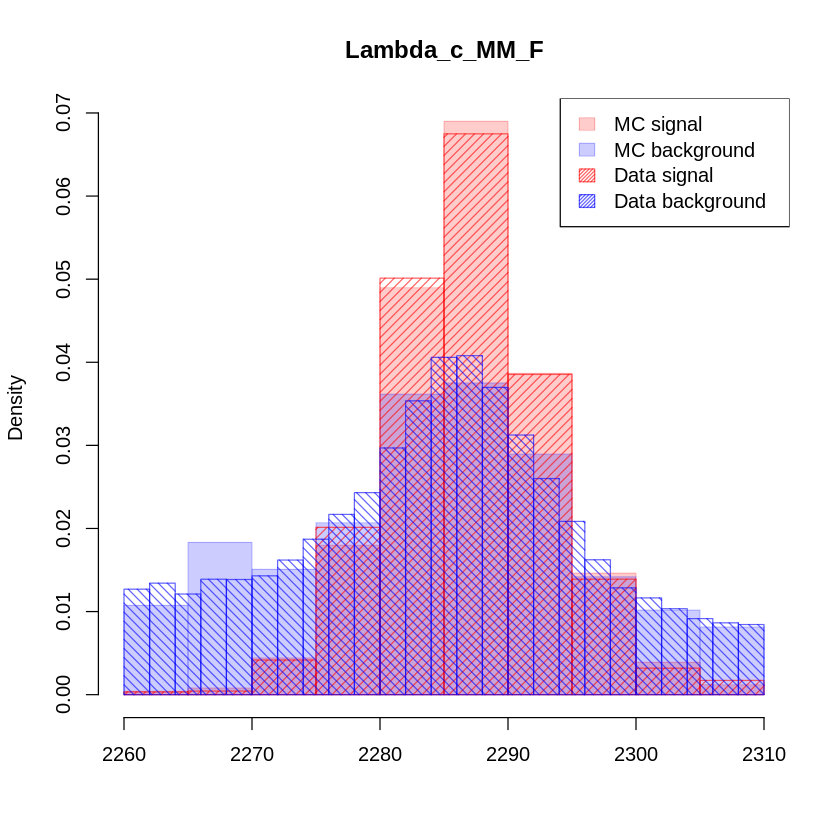

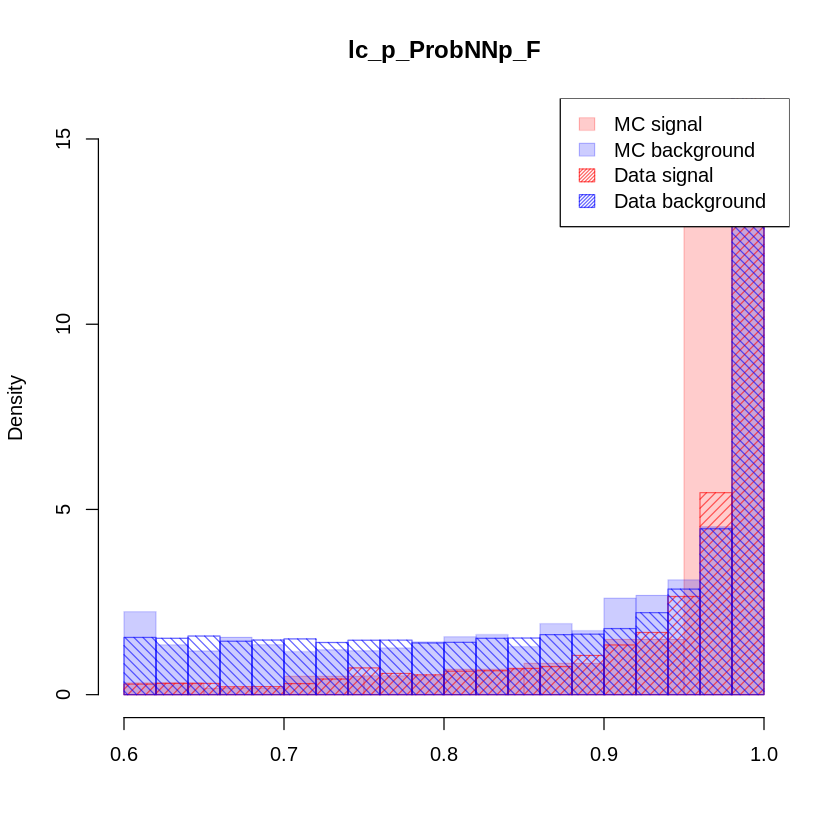

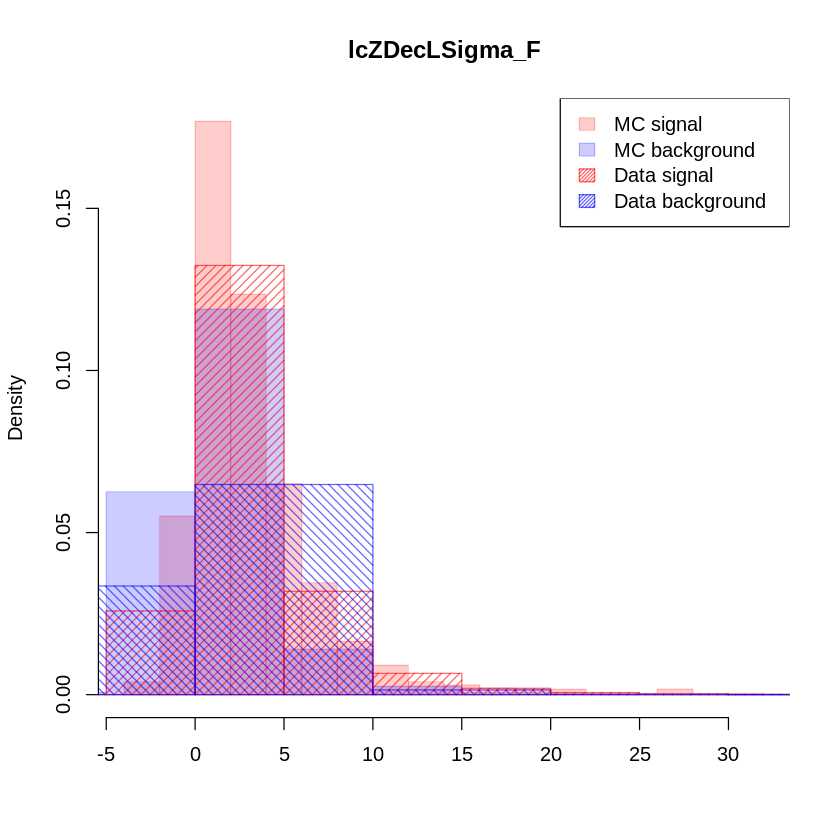

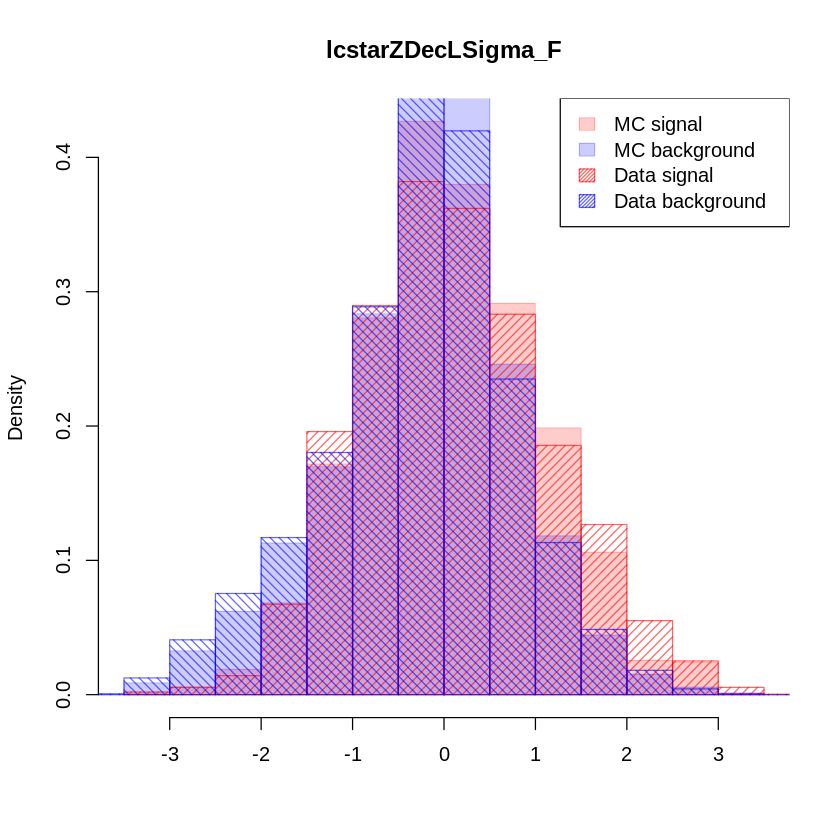

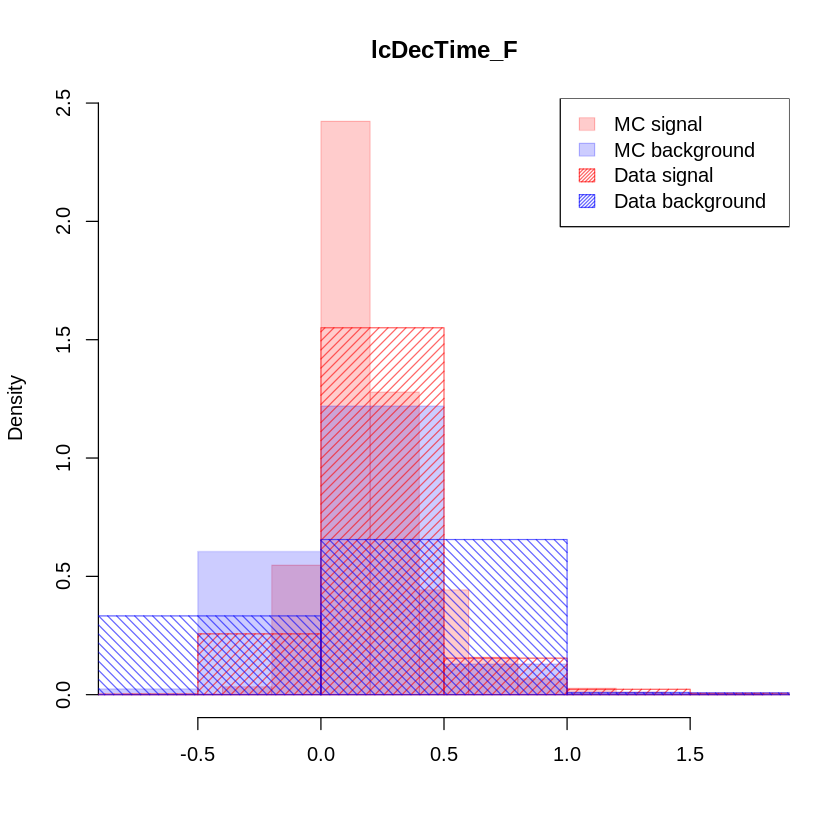

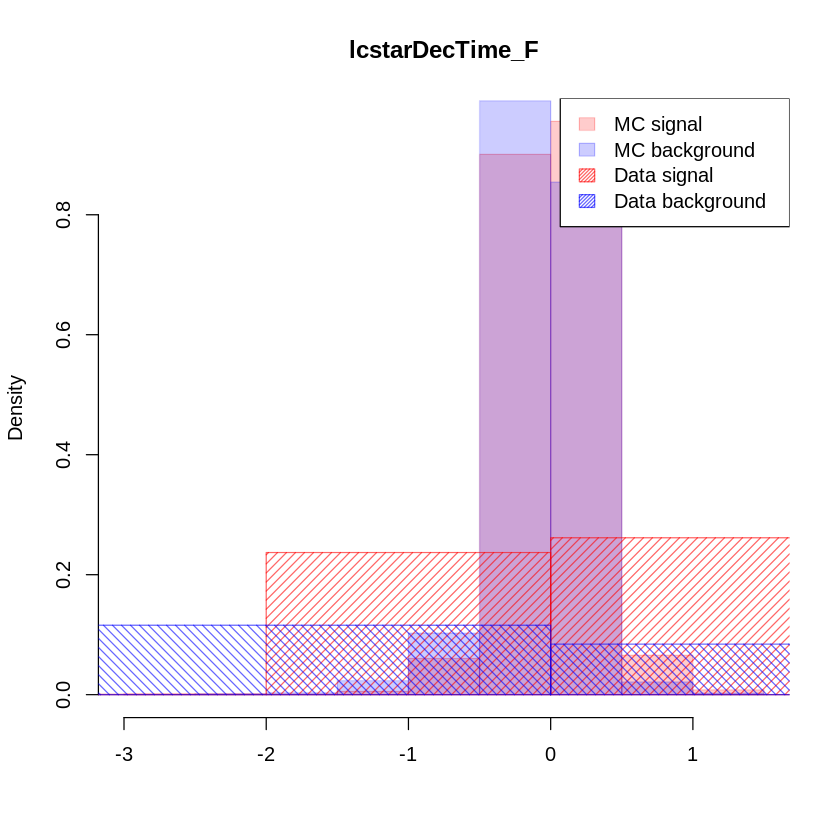

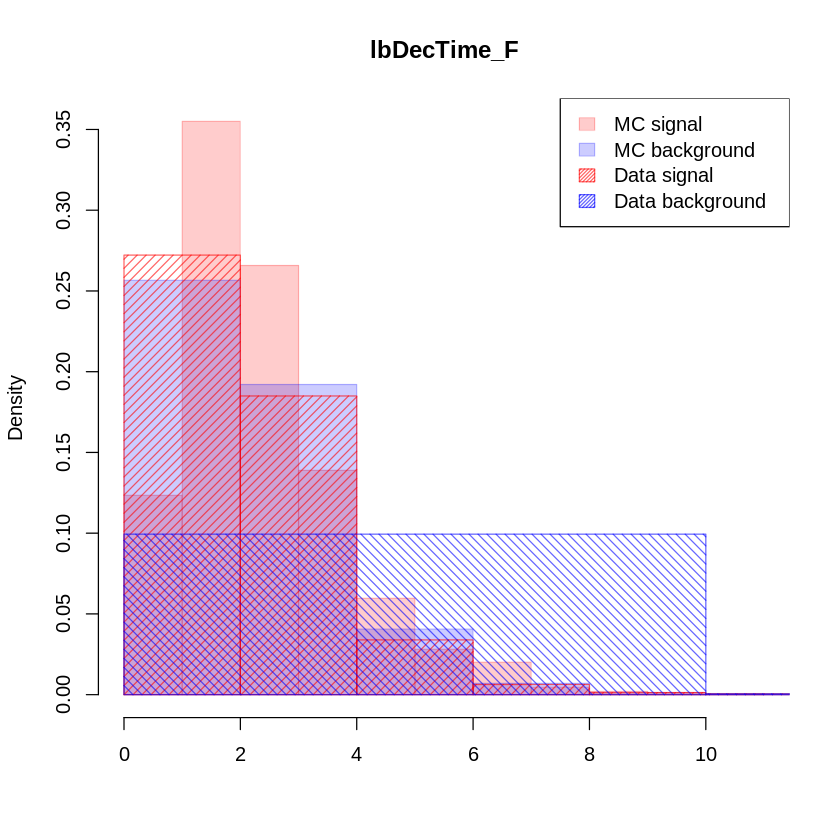

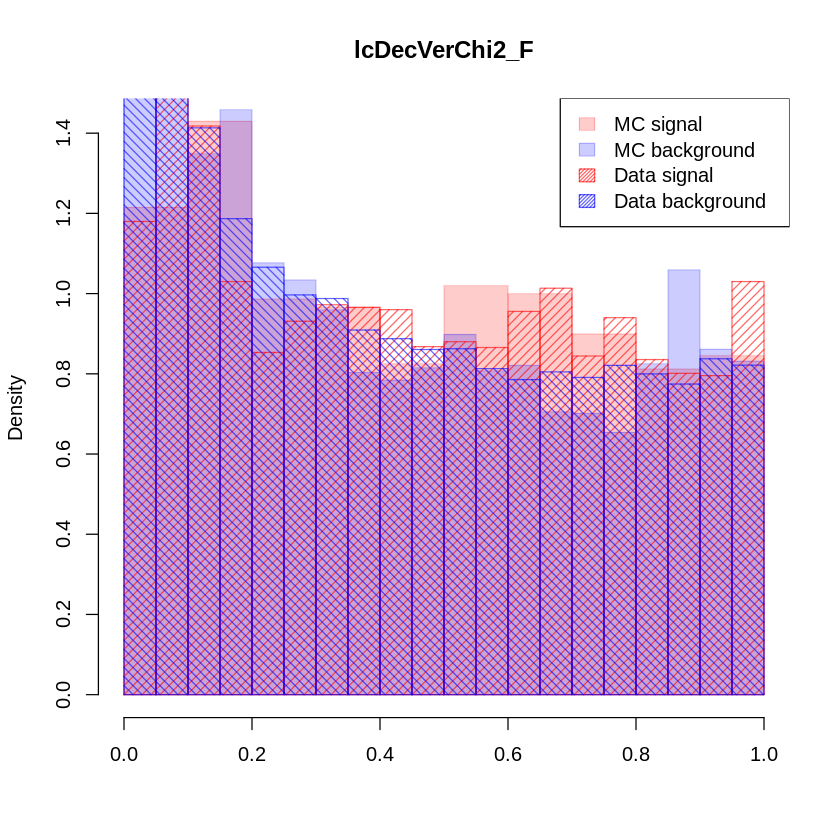

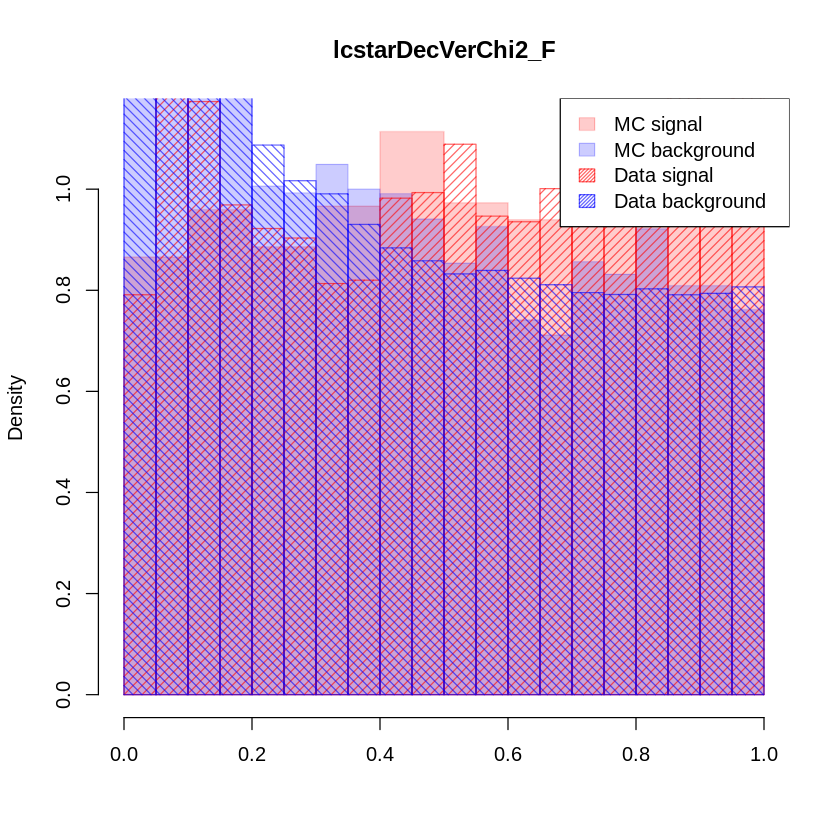

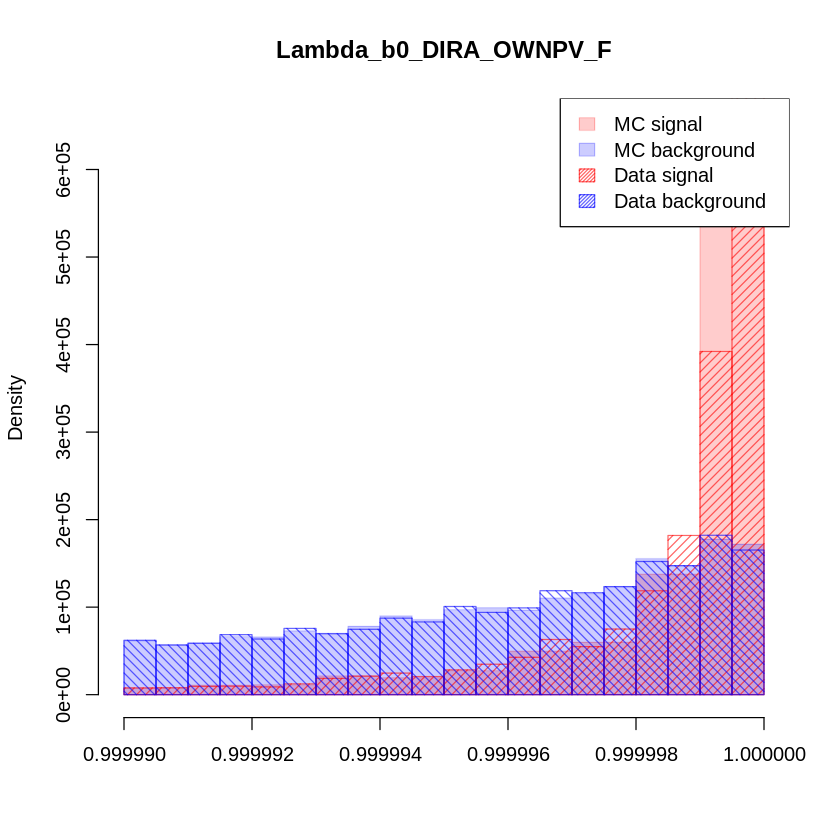

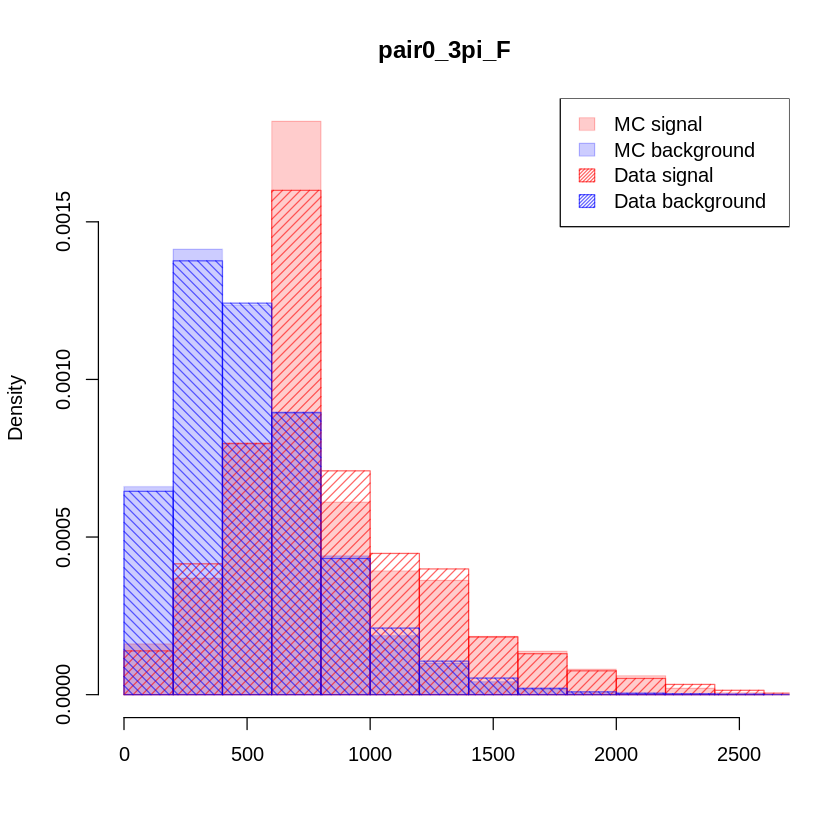

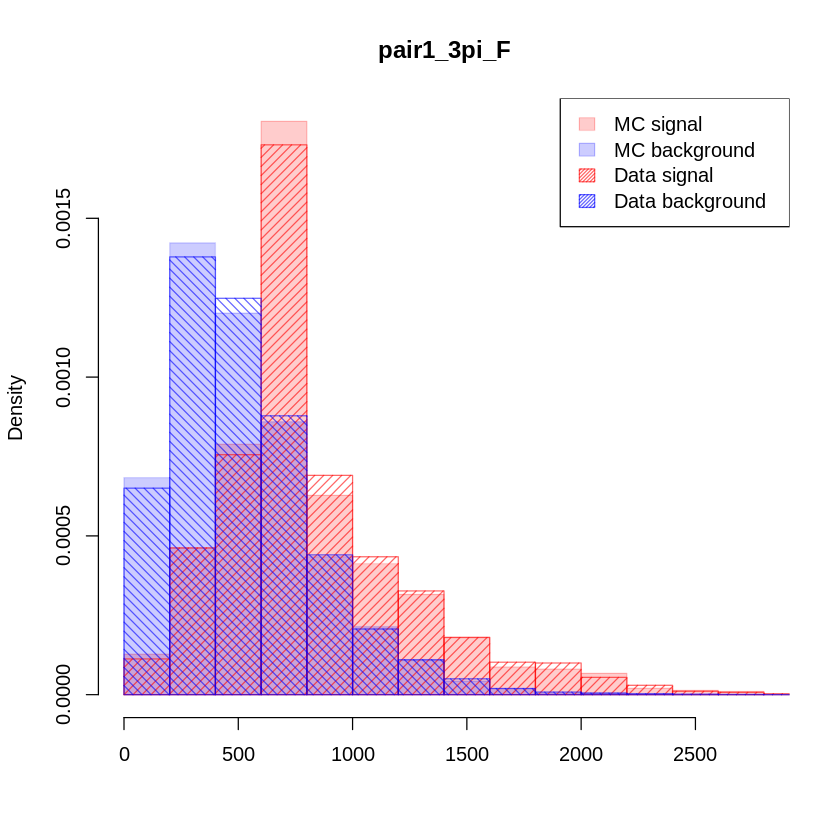

In [15]:
# plot histograms of MC and data distribution, both for signal and background

legend = c("MC signal", "MC background", "Data signal", "Data background")
col  = c(rgb(1,0,0,0.2), rgb(0,0,1,0.2), rgb(1,0,0,0.6), rgb(0,0,1,0.6))

for(f in features){
    hist(signal[[f]],     freq=F, col=col[1], border=col[1], main=f, xlab="")
    hist(background[[f]], freq=F, col=col[2], border=col[2], add=T)
    hist(data_lhcb.signal[[f]], freq=F, col=col[3], border=col[3], density=20, add=T)
    hist(data_lhcb.background[[f]], freq=F, col=col[4], border=col[4], density=20, angle=-45, add=T)
    
    legend(x="topright", legend=legend, col=col, fill=col, border=col, density=c(NA,NA, 50,50))
    
}

In [16]:
# save some significative plots
features.selected <- c("Lambda_c_MM_F", "lc_p_ProbNNp_F", "Lambda_b0_DIRA_OWNPV_F", "pair0_3pi_F", "pair1_3pi_F")
legend <- c("MC signal", "MC background", "Data signal", "Data background")
col    <- c(rgb(1,0,0,0.2), rgb(0,0,1,0.2), rgb(1,0,0,0.6), rgb(0,0,1,0.6))

for(f in features.selected){
    pdf(paste0("Figure/BDT/", f, ".pdf"))
    hist(signal[[f]],     freq=F, breaks=15, col=col[1], border=col[1], main=f, xlab="")
    hist(background[[f]], freq=F, breaks=15, col=col[2], border=col[2], add=T)
    hist(data_lhcb.signal[[f]], freq=F, breaks=15, col=col[3], border=col[3], density=20, add=T)
    hist(data_lhcb.background[[f]], freq=F, breaks=15, col=col[4], border=col[4], density=20, angle=-45, add=T)
    
    legend.position <- ifelse(f=="Lambda_b0_DIRA_OWNPV_F" | f=="lc_p_ProbNNp_F", "top", "topright")
    legend(x=legend.position, legend=legend, col=col, fill=col, border=col, density=c(NA,NA, 50,50))
    dev.off()
    
}